# Снижение дисперсии при A/B тестировании с помощью контрольных перменных, описанное в разделе 3 отчета о НИР.

Предположим, что в процессе проведения A/B теста нам доступны пары наблюдений $(X_i, Y_i)_{i=1}^n$, где $X_i$ и $Y_i~-~$ признаки и значение целевой метрики для $i$-го пользователя соотвественно. Суть метода контрольных переменных заключается в том, чтобы на основании значения признаков $X$ построить такую случайную величину $\zeta$ с известным математическим ожиданием и конечной дисперсией, что
$$
Var(Y +\zeta) \ll Var(Y)\,.
$$
В таком случае выводы о наличие эффекта при A/B тестировании будут делаться на основании разницы в средних, обнаруживаемой в наборе величин $\{Y_i + \zeta_i\}$, обладающих меньшей дисперсией. Таким образом, за счет снижения дисперсии $\{Y_i + \zeta_i\}$ можно снизить размер выборки, требуемый для получения статистически значимых результатов.

In [7]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from tqdm.notebook import tqdm
import itertools

#для запуска части ноутбука с генерацией данных раскомментируйте
#import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder
from scipy import stats

from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, \
    BaseShuffleSplit, _validate_shuffle_split

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline

Код в следующей ячейке копирует (открытую) библиотеку iterstrat, распространяемую под открытой лицензией BSD-3. Подробнее с кодом библиотеки можно ознакомиться по ссылке https://github.com/trent-b/iterative-stratification

In [8]:
"""This file includes multilabel cross validators based on an implementation of
the Iterative Stratification algorithm described in the following paper:
Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-
Label Data. In: Gunopulos D., Hofmann T., Malerba D., Vazirgiannis M. (eds)
Machine Learning and Knowledge Discovery in Databases. ECML PKDD 2011. Lecture
Notes in Computer Science, vol 6913. Springer, Berlin, Heidelberg.

From scikit-learn 0.19.0, StratifiedKFold, RepeatedStratifiedKFold, and
StratifiedShuffleSplit were copied and modified, retaining compatibility
with scikit-learn.

Attribution to authors of scikit-learn/model_selection/_split.py under BSD 3 clause:
    Alexandre Gramfort <alexandre.gramfort@inria.fr>,
    Gael Varoquaux <gael.varoquaux@normalesup.org>,
    Olivier Grisel <olivier.grisel@ensta.org>,
    Raghav RV <rvraghav93@gmail.com>
"""

# Author: Trent J. Bradberry <trentjason@hotmail.com>
# License: BSD 3 clause

def IterativeStratification(labels, r, random_state):
    """This function implements the Iterative Stratification algorithm described
    in the following paper:
    Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of
    Multi-Label Data. In: Gunopulos D., Hofmann T., Malerba D., Vazirgiannis M.
    (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD
    2011. Lecture Notes in Computer Science, vol 6913. Springer, Berlin,
    Heidelberg.
    """

    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)

    # Calculate the desired number of examples at each subset
    c_folds = r * n_samples

    # Calculate the desired number of examples of each label at each subset
    c_folds_labels = np.outer(r, labels.sum(axis=0))

    labels_not_processed_mask = np.ones(n_samples, dtype=bool)

    while np.any(labels_not_processed_mask):
        # Find the label with the fewest (but at least one) remaining examples,
        # breaking ties randomly
        num_labels = labels[labels_not_processed_mask].sum(axis=0)

        # Handle case where only all-zero labels are left by distributing
        # across all folds as evenly as possible (not in original algorithm but
        # mentioned in the text). (By handling this case separately, some
        # code redundancy is introduced; however, this approach allows for
        # decreased execution time when there are a relatively large number
        # of all-zero labels.)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break

        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]

        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]

        for sample_idx in sample_idxs:
            # Find the subset(s) with the largest number of desired examples
            # for this label, breaking ties by considering the largest number
            # of desired examples, breaking further ties randomly
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]

            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]

                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]

            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False

            # Update desired number of examples
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds


class MultilabelStratifiedKFold(_BaseKFold):
    """Multilabel stratified K-Folds cross-validator
    Provides train/test indices to split multilabel data into train/test sets.
    This cross-validation object is a variation of KFold that returns
    stratified folds for multilabel data. The folds are made by preserving
    the percentage of samples for each label.
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds. Must be at least 2.
    shuffle : boolean, optional
        Whether to shuffle each stratification of the data before splitting
        into batches.
    random_state : int, RandomState instance or None, optional, default=None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedKFold that only uses random_state
        when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> mskf = MultilabelStratifiedKFold(n_splits=2, random_state=0)
    >>> mskf.get_n_splits(X, y)
    2
    >>> print(mskf)  # doctest: +NORMALIZE_WHITESPACE
    MultilabelStratifiedKFold(n_splits=2, random_state=0, shuffle=False)
    >>> for train_index, test_index in mskf.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    Notes
    -----
    Train and test sizes may be slightly different in each fold.
    See also
    --------
    RepeatedMultilabelStratifiedKFold: Repeats Multilabel Stratified K-Fold
    n times.
    """

    def __init__(self, n_splits=3, *, shuffle=False, random_state=None):
        super(MultilabelStratifiedKFold, self).__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def _make_test_folds(self, X, y):
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(type_of_target_y))

        num_samples = y.shape[0]

        rng = check_random_state(self.random_state)
        indices = np.arange(num_samples)

        if self.shuffle:
            rng.shuffle(indices)
            y = y[indices]

        r = np.asarray([1 / self.n_splits] * self.n_splits)

        test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

        return test_folds[np.argsort(indices)]

    def _iter_test_masks(self, X=None, y=None, groups=None):
        test_folds = self._make_test_folds(X, y)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedKFold, self).split(X, y, groups)


class RepeatedMultilabelStratifiedKFold(_RepeatedSplits):
    """Repeated Multilabel Stratified K-Fold cross validator.
    Repeats Mulilabel Stratified K-Fold n times with different randomization
    in each repetition.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    n_repeats : int, default=10
        Number of times cross-validator needs to be repeated.
    random_state : None, int or RandomState, default=None
        Random state to be used to generate random state for each
        repetition as well as randomly breaking ties within the iterative
        stratification algorithm.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> rmskf = RepeatedMultilabelStratifiedKFold(n_splits=2, n_repeats=2,
    ...     random_state=0)
    >>> for train_index, test_index in rmskf.split(X, y):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    ...
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [0 1 4 5] TEST: [2 3 6 7]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    See also
    --------
    RepeatedStratifiedKFold: Repeats (Non-multilabel) Stratified K-Fold
    n times.
    """
    def __init__(self, n_splits=5, *, n_repeats=10, random_state=None):
        super(RepeatedMultilabelStratifiedKFold, self).__init__(
            MultilabelStratifiedKFold, n_repeats=n_repeats, random_state=random_state,
            n_splits=n_splits)


class MultilabelStratifiedShuffleSplit(BaseShuffleSplit):
    """Multilabel Stratified ShuffleSplit cross-validator
    Provides train/test indices to split data into train/test sets.
    This cross-validation object is a merge of MultilabelStratifiedKFold and
    ShuffleSplit, which returns stratified randomized folds for multilabel
    data. The folds are made by preserving the percentage of each label.
    Note: like the ShuffleSplit strategy, multilabel stratified random splits
    do not guarantee that all folds will be different, although this is
    still very likely for sizeable datasets.
    Parameters
    ----------
    n_splits : int, default 10
        Number of re-shuffling & splitting iterations.
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set to 0.1.
        The default will change in version 0.21. It will remain 0.1 only
        if ``train_size`` is unspecified, otherwise it will complement
        the specified ``train_size``.
    train_size : float, int, or None, default is None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedShuffleSplit that only uses
        random_state when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.5,
    ...    random_state=0)
    >>> msss.get_n_splits(X, y)
    3
    >>> print(mss)       # doctest: +ELLIPSIS
    MultilabelStratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,
                                     train_size=None)
    >>> for train_index, test_index in msss.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    TRAIN: [1 2 5 6] TEST: [0 3 4 7]
    Notes
    -----
    Train and test sizes may be slightly different from desired due to the
    preference of stratification over perfectly sized folds.
    """

    def __init__(self, n_splits=10, *, test_size="default", train_size=None,
                 random_state=None):
        super(MultilabelStratifiedShuffleSplit, self).__init__(
            n_splits=n_splits, test_size=test_size, train_size=train_size, random_state=random_state)

    def _iter_indices(self, X, y, groups=None):
        n_samples = _num_samples(X)
        y = check_array(y, ensure_2d=False, dtype=None)
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(
                    type_of_target_y))

        n_train, n_test = _validate_shuffle_split(n_samples, self.test_size,
                                                  self.train_size)

        n_samples = y.shape[0]
        rng = check_random_state(self.random_state)
        y_orig = y.copy()

        r = np.array([n_train, n_test]) / (n_train + n_test)

        for _ in range(self.n_splits):
            indices = np.arange(n_samples)
            rng.shuffle(indices)
            y = y_orig[indices]

            test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

            test_idx = test_folds[np.argsort(indices)] == 1
            test = np.where(test_idx)[0]
            train = np.where(~test_idx)[0]

            yield train, test

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedShuffleSplit, self).split(X, y, groups)

In [9]:
def get_coef_significance(X, Y): 
    """
    Функция для оценки статистической значимость коэффициентов линейной регрессии

    Параметры:
        X - DataFrame - данные, содержащие несколько объектов с признаками
        Y - array - целевая метрика для объектов из X

    Выход:
        table - DataFrame - таблица со значениями p-value, относительно которых можно делать вывод о статистической значимости коэффициента при каждом признаке в X.
        lin_reg - statsmodels.OLS - обученная модель регрессии
    """
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y

    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    table = pd.read_html(summary.as_html(), header=0, index_col=0)[0]
    return table, lin_reg

In [10]:
def check_pval(pval):
    """
    Функция для автоматической проверки p-value на статистическую значимость

    Параметры:
        pval - float - значение p-value
    """  
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [11]:
def ttest(x, y, randomized=False, verbose=False):
    """
    Функция для проведения T-testa в двух модификациях: с обычной и с рандомизированной T-статистикой.

    Параметры:
        x - array - значение целевой метрики в тестовой группе
        y - array - значение целевой метрики в контрольной группе
        randomized - bool - индикатор того, какой тест проводить (рандомизированный - 1, стандартный - 0)
        verbose - bool - печатать ли вспомогательную информацию
        
    Выход:
         полученное в T-тесте p-value (float)
    """ 
    #число элементов в тестовой группе
    n_x = x.shape[0]
    #число элементов в контрольной группе
    n_y = y.shape[0]

    #дисперсия целевой метрики в тестовой группе
    s_x = np.var(x, ddof=1)
    #дисперсия целевой метрики в контрольной группе
    s_y = np.var(y, ddof=1)
    #рандомизированный тест
    if randomized:
        #подсчет числа степеней свободы знаменателя при T-тесте
        dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
        #генерация вектора весов с единичной сферы, удовлетворяющего условиям теоремы Клартага-Содина. 
        #используемый вектор основывается на повторении блоков (1,\sqrt{2},1,\sqrt{2}) и (1,\sqrt{2},-1,-\sqrt{2}) и их последующей нормировке
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        #вектор весов для тестовой группы
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        theta_x = theta_x[:n_x]
        #вектор весов для контрольной группы
        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        theta_y = theta_y[:n_y]
        #подсчет Т-статистики
        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        #p-value для двустороннего теста
        p = 2*(stats.t.cdf(-abs(t_val), dof))
    #не рандомизированный тест, используется стандартный Т-тест
    else: 
        t_val, p = stats.ttest_ind(x, y, equal_var=False)     
    if verbose:
        check_pval(p)
    return p

# Обработка датасета и генерация подвыборок

In [12]:
## Для скачивания датасета раскомментировать следующий код
!wget http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz
!gzip -d ./criteo-research-uplift-v2.1.csv.gz

--2023-11-17 13:31:33--  http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz
Распознаётся go.criteo.net (go.criteo.net)… 178.250.7.18
Подключение к go.criteo.net (go.criteo.net)|178.250.7.18|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo-uplift-v2.1.csv.gz [переход]
--2023-11-17 13:31:34--  https://criteostorage.blob.core.windows.net/criteo-research-datasets/criteo-uplift-v2.1.csv.gz
Распознаётся criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)… 20.209.1.1
Подключение к criteostorage.blob.core.windows.net (criteostorage.blob.core.windows.net)|20.209.1.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 311422618 (297M) [application/x-gzip]
Сохранение в: «criteo-research-uplift-v2.1.csv.gz»

criteo-research-upl 100%[===================>] 297,00M   910KB/s    за 4m 19s  

2023-11-17 13:35:57 (1,15 MB/s) - «cr

В случае, если у вас не работает утилита wget - датасет нужно скачать вручную по ссылке выше и распаковать из архива в .csv файл с названием 'criteo-research-uplift-v2.1.csv'

In [13]:
#считывание датасета
inp_df = pd.read_csv('criteo-research-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')
df = inp_df 

X = features
y = 'visit'
t = 'treatment'

In [14]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [15]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'p-value по всем данных: {p}')

p-value по всем данных: 0.0


## Генерация стратифицированной подвыборки меньшего размера

В данной подвыборке с помощью стандартного Т-теста нулевая гипотеза 
$$\mathcal{H_0}: \mu_1 = \mu_2\, ,$$
не отвергается при истинности альтернативной
$$\mathcal{H_1}: \mu_1 \neq \mu_2\, ,$$

где $\mu_1$ и $\mu_2$ - математические ожидания в тестовой и контрольной выборках. Таким образом, размеры сгенерированных подвыборок недостаточны для того, чтобы обнаружить величину эффекта, равную $\mu_1 - \mu_2$.

Стратифицированная подвыборка генерируется с помощью MultilabelStratifiedShuffleSplit

In [16]:
columns = ['f0', 'f2', 'f8', 'f9', 'visit']
columns

['f0', 'f2', 'f8', 'f9', 'visit']

In [17]:
all_control = df.loc[df['treatment'] == 0]
all_treatment = df.loc[df['treatment'] == 1]

In [18]:
scale = all_treatment.shape[0] / all_control.shape[0]
scale

5.666672389299249

In [87]:
control_sample = pd.read_pickle("saved_variables/control_sample.pkl")  
treatment_sample = pd.read_pickle("saved_variables/treatment_sample.pkl")
control_sample_1 = pd.read_csv("saved_variables/control_sample.csv") 

In [91]:
from pandas.util.testing import assert_frame_equal

In [93]:
#assert_frame_equal(control_sample, control_sample_1)
print(control_sample.shape)
print(control_sample_1.shape)

(1049, 16)
(1049, 17)


In [100]:
control_sample.head()
for col in control_sample.columns:
    print(col)
print(len(control_sample.columns))

f0
f1
f2
f3
f4
f5
f6
f7
f8
f9
f10
f11
treatment
conversion
visit
exposure
16


In [99]:
control_sample_1.head()
for col in control_sample_1.columns:
    print(col)

Unnamed: 0
f0
f1
f2
f3
f4
f5
f6
f7
f8
f9
f10
f11
treatment
conversion
visit
exposure


### В данной секции стратифицированным образом отбирается заданное число подвыборок размера 0.0005 от всего датасета. Если вы не хотите ждать, пока они будут сгенерированы, пропустите данную секцию и загрузите готовые данные из ячейки выше. В противном случае - раскомментируйте код ниже.

In [57]:
#size_control = 0.0005
#scale = all_treatment.shape[0] / all_control.shape[0]
#size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

#msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=0)
#msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=0)

In [58]:
#trval_i, control_sample_i = next(msss_control.split(all_control.values, all_control.loc[:, columns].values))
#trval_i, treatment_sample_i = next(msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values))

In [59]:
#control_sample = all_control.iloc[control_sample_i]
#treatment_sample = all_treatment.iloc[treatment_sample_i]

In [60]:
#print(control_sample)

In [61]:
#print(f"treatment: {treatment_sample.shape[0]}, control: {control_sample.shape[0]}, frac: {treatment_sample.shape[0] / control_sample.shape[0]}")


In [62]:
#control_size = 0.0005
#stats.ttest_ind(treatment_sample['visit'], control_sample['visit'], equal_var=False, random_state=1)

In [63]:
#print(f"Дисперсия в подвыборках: контроль {control_sample['visit'].var()}, тест {treatment_sample['visit'].var()}")

## Генерация исторического контекста

Генерация стратифицированной подвыборки, которая соответствует предэкспериментальному периоду.

Стратифицированная подвыборка генерируется с помощью MultilabelStratifiedShuffleSplit

In [66]:
# # Код ниже в этой секции можно не запускать, а скачать сохраненную подвыборку
control_sample_hist = pd.read_pickle("saved_variables/control_sample_hist.pkl")  
treatment_sample_hist = pd.read_pickle("saved_variables/treatment_sample_hist.pkl")

In [67]:
#all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample.index))]
#all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample.index))]

In [68]:
#size_control = 0.0005
#scale = all_treatment_for_hist.shape[0] / all_control_for_hist.shape[0]
#size_treatment = int(scale * size_control * all_control_for_hist.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

#msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=2)
#msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=2)

In [69]:
#trval_i, control_sample_hist_i = next(msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values))
#trval_i, treatment_sample_hist_i = next(msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values))

In [70]:
#control_sample_hist = all_control_for_hist.iloc[control_sample_hist_i]
#treatment_sample_hist = all_treatment_for_hist.iloc[treatment_sample_hist_i]

In [71]:
#print(f"treatment: {treatment_sample_hist.shape[0]}, control: {control_sample_hist.shape[0]}, frac: {treatment_sample_hist.shape[0] / control_sample_hist.shape[0]}")

## Генерация подвыборки с увеличивающимся размером

Генерация стратифицированных подвыборок размерами от 420 до 4200 с шагом 420 для эксперимента, описанного в разделе 3.4.1 отчета о НИР.

Стратифицированные подвыборки генерируются с помощью MultilabelStratifiedShuffleSplit

In [72]:
all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]

In [73]:
# ## Код ниже в этой секции можно не запускать, а скачать сохраненную подвыборку из папки saved_variables
n_splits = 10
#Большие размеры выборок для теста и контроля
control_indexes_big = []
treatment_indexes_big = []
for i in range(n_splits):
    control_indexes_big.append(pd.read_pickle(f"saved_variables/control_data_split_35e-5_{i}.pkl")) 
    treatment_indexes_big.append(pd.read_pickle(f"saved_variables/treatment_data_split_35e-5_{i}.pkl"))

#Маленькие размеры выборок для теста и контроля
control_indexes_small = []
treatment_indexes_small = []
for i in range(n_splits):
    control_indexes_small.append(pd.read_pickle(f"saved_variables/control_data_split_2e-4_{i}.pkl"))
    treatment_indexes_small.append(pd.read_pickle(f"saved_variables/treatment_data_split_2e-4_{i}.pkl")) 

all_in_slit_control = []
all_in_slit_treatment = []

for i in tqdm(range(0, len(control_indexes_small))):
    all_in_slit_control.extend(control_indexes_small[i].index)
    all_in_slit_treatment.extend(treatment_indexes_small[i].index)
    
for i in tqdm(range(0, len(control_indexes_big))):
    all_in_slit_control.extend(control_indexes_big[i].index)
    all_in_slit_treatment.extend(treatment_indexes_big[i].index)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
#size_control = 0.00035
#n_splits = 10

#all_control.shape[0] * size_control

In [75]:
#size_control = 0.00035
#scale = all_treatment.shape[0] / all_control.shape[0]
#size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

#msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_control, random_state=3)
#msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_treatment, random_state=3)

In [76]:
#control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
#treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)

In [77]:
#%%time

#control_indexes = list(control_generator)
#treatment_indexes = list(treatment_generator)

In [78]:
#data_control = []
#data_treatment = []

#for i in tqdm(range(0, len(control_indexes))):
#    data_control.append(all_control.iloc[control_indexes[i][1]])
#    data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])

# Методы снижения дисперсии при помощи контрольных переменных

## Метод CUPED из раздела 3.1 отчета о НИР

A. Deng, Y. Xu, R. Kohavi, T. Walker. "Improving the sensitivity of online controlled experiments by utilizing pre-experiment data"

In [79]:
def modify_with_cuped(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder="OHE", verbose=False):
    """
    Применение метода CUPED к контрольной и тестовой выборкам.
        

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        pipeline - bool - индикатор дополнительного преобразования признаков
        encoder - str - какой энкодер использовать, если pipeline=True
        verbose - bool - печатать ли впомогательную информацию 
    Выход:
        p-value - float - значение p-value до и после применения CUPED
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    #для обучения контрольной переменной используется предыстория для контрольной и экспериментальной групп
    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)
    #выделим целевую переменную
    Y = X['visit']
    #выделим значимые признаки
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))


    # Применение пайплайна обработки категориальных признаков (если pipeline=True) и обучение модели
    
    if pipeline:
        #центрируем числовые признаки
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        #one-hot-encoding для категориальных признаков (по умолчанию)
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")
        #применить заданную предобработку к 
        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            #раскомментировать строчку ниже в более новых версиях sklearn
            #verbose_feature_names_out=False,
        )
        #общий пайплайн из предобработки и линейной регрессии
        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        #фит на данных
        reg.fit(X, Y)
        #центрируем признаки в контрольной и тестовых группах на исторические средние
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        #просто центрируем все признаки и обучаем линейную регрессию
        means = np.mean(X)
        X = X - means

        reg = Pipeline(
            [
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        reg.fit(X, Y)
        #центрируем признаки в контрольной и тестовых группах на исторические средние
        c = control[columns] - means
        e = experimental[columns] - means

    y_c = control['visit']
    y_e = experimental['visit']
    # Изменение целевой переменной
    control_cuped = y_c - reg.predict(c) + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    #p-значения для (нерандомизированного) t-теста до и после применения CUPED
    p_before = ttest(y_c, y_e)
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

## Метод CUPAC из раздела 3.2 отчета о НИР

A. Poyarkov, A. Drutsa, A. Khalyavin, G. Gusev, P. Serdyukov. "Boosted decision tree regression adjustment for variance reduction in online controlled experiments."

In [80]:
def modify_with_cupac(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder='OHE', verbose=False):
    """
    Применение метода CUPAC к контрольной и тестовой выборкам

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        pipeline - bool - индикатор дополнительного преобразования признаков
        encoder - str - какой энкодер использовать, если pipeline=True
        verbose - bool - печатать ли впомогательную информацию 
    Выход:
        p-value - float - значение p-value до и после применения CUPAC
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)


    Y = X['visit']
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))
    
    # Применение пайплайна обработки категориальных признаков (если pipeline=True) и обучение модели
    if pipeline:
        
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            #раскомментировать строчку ниже в более новых версиях sklearn
            #verbose_feature_names_out=False,
        )

        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2)),
            ]
        )
        reg.fit(X, Y)
        
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        means = np.mean(X)
        X = X - means
        
        reg = Pipeline(
            [
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2)),
            ]
        )
        reg.fit(X, Y)
    
        c = control[columns] - means
        e = experimental[columns] - means
    


    y_c = control['visit']
    y_e = experimental['visit']

    
    # Изменение целевой переменной
    control_cuped = y_c - reg.predict(c)  + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()

    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

## Метод ML-rate из раздела 3.3 отчета о НИР

Y. Guo, D. Coey, M. Konutgan, W. Li, C. Schoener, M. Goldman. "Machine learning for variance reduction in online experiments."

In [81]:
def modify_with_ml_rate(control, experimental, control_hist, experimental_hist, columns, verbose=False, aa=False):
    """
    Применение метода Ml-rate к контрольной и тестовой выборкам

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        control_hist - DataFrame - объекты, относящиеся к историческим данным
        experimental_hist - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        verbose - bool - печатать ли впомогательную информацию 
        aa - bool - проводится ли AA тест
    Выход:
        p-value - float - значение p-value до и после применения Ml-rate
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    
    if aa:
        experimental['treatment'] = 1
        
    Z = pd.concat((control, experimental, control_hist, experimental_hist), axis=0).sample(frac=1)
    means = np.mean(Z[columns])

    Y = Z['visit']
    X = Z[columns]
    X = X - means.values
    X = pd.concat((X, Z['treatment']), axis=1)
    
    # Обучение модели линейной регрессии
    table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X), Y)
    p_after = table_summary.iloc[-1, :]['P>|t|']
    
    return p_after

# Отбор признаков 

Для метода CUPED были выбраны наиболее значимые признаки из датасета при обучении линейной регрессии.

Для метода CUPAC - с помощью Permutation Feature Importance. Данный подход основан на том, что при изменении значений конкретного признака (путем случайной перестановки или перемешивания) и оценке влияния этого изменения на метрику качества модели можно определить, насколько важен этот признак для модели.

In [82]:
cols_regr_ordinal = ['f6', 'f8', 'f9', 'f0', 'f2']
cols_boosting = ['f2', 'f0', 'f9', 'f10', 'f4', 'f7', 'f8']

# Эксперимент с размером исторических данных из раздела 3.4.2 отчета о НИР

In [83]:
def draw_graphics(before=None, after_cup=None, after_gb=None, p_after_reg=None, title='', alpha=0.05):
    """
    Функция для отрисовки результатов работы методов

    Параметры:
        before - array - значения p-value для метода с использование изначальной целевой переменной
        after_cup - array - значения p-value для метода с использование целевой переменной, модифицированной методов CUPED
        after_gb - array - значения p-value для метода с использование целевой переменной, модифицированной методов CUPAC
        after_reg - array - значения p-value для метода с использование целевой переменной, модифицированной методов Ml-rate
        title - str - дополнительная над графиками
        alpha - float - уровень значимости
    """
    if len(title) != 0:
        print('\n', title, '\n')
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    ax1.plot(shapes, [alpha] * len(shapes), color="red", linestyle='dashed', label='alpha')
    if not (before is None):
        ax1.plot(shapes, before, marker='o', ms=5, label='Default')
        ax2.plot(shapes, np.log(before), marker='o', ms=5, label='Default')
    if not (after_cup is None):
        ax1.plot(shapes, after_cup, marker='o', ms=5, label='CUPED')
        ax2.plot(shapes, np.log(after_cup), marker='o', ms=5, label='CUPED')
    if not (after_gb is None):
        ax1.plot(shapes, after_gb, marker='o', ms=5, label='CUPAC')
        ax2.plot(shapes, np.log(after_gb), marker='o', ms=5, label='CUPAC')
    if not (p_after_reg is None):
        ax1.plot(shapes, p_after_reg, marker='o', ms=5, label='Ml-rate')
        ax2.plot(shapes, np.log(p_after_reg), marker='o', ms=5, label='Ml-rate')
    ax1.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax1.set_ylabel('p-value', fontsize=15)
#     ax1.set_title(f'Поведение p-value в зависимости от размера выборки', fontsize=15)

    ax2.plot(shapes, [np.log(alpha)] * len(shapes), color="red", linestyle='dashed', label='alpha')
    ax2.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax2.set_ylabel('log p-value', fontsize=15)
#     ax2.set_title(f'Поведение log p-value в зависимости от размера выборки',fontsize=15)

    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')

## Очень маленький исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [84]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist.sample(100, random_state=1)
    hist_e = treatment_sample_hist.sample(100, random_state=1)
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_cupac(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_ml_rate(all_test_control, all_test_treatment, hist_c, hist_e, cols3)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

  0%|          | 0/10 [00:00<?, ?it/s]


 Маленькие фолды: 420
Маленькая история: 200 



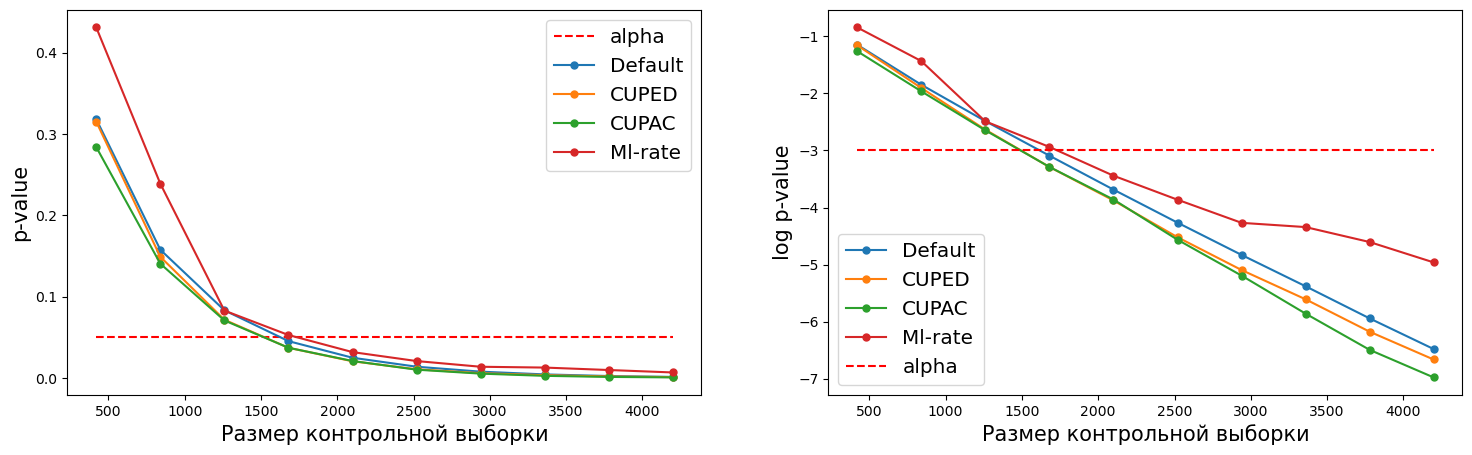

In [85]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

## Маленький исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [ ]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]
    
    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist.sample(450, random_state=1)
    hist_e = treatment_sample_hist.sample(int(scale * 450), random_state=1)
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_cupac(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_ml_rate(all_test_control, all_test_treatment, hist_c, hist_e, cols3)

    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

In [ ]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

## Большой исторический контекст (см. раздел отчета 3.4.2 для более подробного описания постановки задач)

In [ ]:
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal
cols2 = cols_boosting
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]
    
    # Добавление элементов в выборку с прошлого шага
    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    # Выбор исторического контекста
    hist_c = control_sample_hist
    hist_e = treatment_sample_hist
    
    # Запуск методов
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, hist_c, hist_e, cols1, True, encoder="Ord", verbose=False)
    p_bef, p_aft_gb = modify_with_cupac(all_test_control, all_test_treatment, hist_c, hist_e, cols2, False, verbose=False)
    p_aft_reg = modify_with_ml_rate(all_test_control, all_test_treatment, hist_c, hist_e, cols3)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

In [ ]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {hist_c.shape[0] + hist_e.shape[0]}')
plt.show()

# Эксперимент по сравнению методов, описанный в разделе 3.4.1 отчета о НИР

In [ ]:
sizes = [400, 800, 1000, 1200, 1500, 2000]

In [ ]:
columns = ['f0', 'f2', 'f8', 'f9']

Для данного эксперимента было сгенерированно по 10 стратифицированных подвыборок с размерами контрольной группы `400, 800, 1000, 1200, 1500, 2000`. На каждой паре подвыборки из тестовой и контрольной групп замерялось p-value до и после применения различных методов снижения дисперсии. По 10 запускам был оценен разброс значений. 

Генерация стратифицированных подвыборок проиводилась с помощью MultilabelStratifiedShuffleSplit

In [ ]:
# all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
# all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]
# scale = all_treatment.shape[0] / all_control.shape[0]

#число повторений
#n_repeats = 10

# control_generators = []
# treatment_generators = []

# for size in tqdm(sizes):
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=n_repeats, test_size=size, random_state=size + 5)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=n_repeats, test_size=int(size * scale), random_state=size + 5)
    
#     control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
    
#     data_control = []
#     data_treatment = []

#     for i in tqdm(range(0, len(control_indexes))):
#         data_control.append(all_control.iloc[control_indexes[i][1]])
#         data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])
    
#     print(control_indexes[0][1].shape)

#     joblib.dump(data_control, f'control_data_split_{size}.joblib')
#     joblib.dump(data_treatment, f'treatment_data_split_{size}.joblib')

Генерация исторических данных. Из всего датасета удаляютсяя индексы объектов из тестовой и контрольной выборок одного размера, после чего из оставшихся объектов выбираются пользователи, составляющие исторический контекст.

In [ ]:
# history_size = 1000
# history_scale = scale

# for size in tqdm(sizes):
#     control_ind = joblib.load(f'control_data_split_{size}.joblib')
#     treatment_ind = joblib.load(f'treatment_data_split_{size}.joblib')
    
#     all_in_slit_control = []
#     all_in_slit_treatment = []
    
#     for i in range(0, len(control_ind)):
#         all_in_slit_control.extend(control_ind[i].index)
#         all_in_slit_treatment.extend(treatment_ind[i].index)
        
        
#     all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(all_in_slit_control))]
#     all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(all_in_slit_treatment))]
     
    
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=history_size, random_state=size + 2)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=int(history_size * history_scale), random_state=size + 2)
    
#     control_generator = msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
#     print(control_indexes[0][1].shape)
    
#     hist_control_table = []
#     hist_treatment_table = []
    
#     for i in range(0, len(control_indexes)):
#         hist_control_table.append(all_control_for_hist.iloc[control_indexes[i][1]])
#         hist_treatment_table.append(all_treatment_for_hist.iloc[treatment_indexes[i][1]])


        
        
#     joblib.dump(hist_control_table, f'control_data_hist_{size}.joblib')
#     joblib.dump(hist_treatment_table, f'treatment_data_hist_{size}.joblib')
    

In [ ]:
def run_test(sample_c, sample_t, history_c_ind, history_t_ind):
    """
    Функция для запуска тестов

    Параметры:
        sample_c - list[DataFrame] - объекты контрольной группы
        sample_t - list[DataFrame] - объекты тестовой группы
        history_c_ind - list[DataFrame] - историческая выборка
        history_t_ind - list[DataFrame] - историческая выборка
        
    Выход:
        before - array - значения p-value без применения методов 
        after_cup - array - значения p-value после применения CUPED 
        after_gb - array - значения p-value после применения CUPAC  
        after_reg - array - значения p-value после применения ML-rate  

    """
    before = []
    after_cup = []
    after_gb = []
    after_reg = []

    cols1 = cols_regr_ordinal
    cols2 = cols_boosting
    cols3 = ['f4', 'f11', 'f2']
    
    
    for i in tqdm(range(0, len(sample_c))):
        test_control = sample_c[i]
        test_treatment = sample_t[i]
        
        hist_control = history_c_ind[i]
        hist_treatment = history_t_ind[i]
        
        
        p_bef, p_after_cup = modify_with_cuped(test_control, test_treatment, hist_control, hist_treatment, cols1, True, encoder='Ord')
        p_bef, p_after_gb = modify_with_cupac(test_control, test_treatment, hist_control, hist_treatment, cols2)
        p_aft_reg = modify_with_ml_rate(test_control, test_treatment, hist_control, hist_treatment, cols3)

        
        before.append(p_bef)
        after_cup.append(p_after_cup)
        after_gb.append(p_after_gb)
        after_reg.append(p_aft_reg)
        
    return np.array(before), np.array(after_cup), np.array(after_gb), np.array(after_reg)

In [ ]:
#арзмеры генерируемых подвыборок
sizes = [400, 800, 1000, 1200, 1500, 2000]
#число генерируемых подвыборок
n_repeats = 10

pvals_b = []
pvals_c = []
pvals_gb = []
pvals_reg = []

# Загрузка сгенерированных данных в формате list[DataFrame] и запуск тестов
for size in tqdm(sizes):
    control_ind = []
    treatment_ind = []
    for i in range(n_repeats):
        control_ind.append(pd.read_csv(f"saved_variables/control_data_split_{size}_{i}.csv"))
        treatment_ind.append(pd.read_csv(f"saved_variables/treatment_data_split_{size}_{i}.csv"))

    control_ind_hist = []
    treatment_ind_hist = []
    for i in range(n_repeats):
        control_ind_hist.append(pd.read_csv(f"saved_variables/control_data_hist_{size}_{i}.csv"))
        treatment_ind_hist.append(pd.read_csv(f"saved_variables/treatment_data_hist_{size}_{i}.csv"))
    
    b, c, gb, reg = run_test(control_ind, treatment_ind, control_ind_hist, treatment_ind_hist)
    pvals_b.append(b)
    pvals_c.append(c)
    pvals_gb.append(gb)
    pvals_reg.append(reg)


In [ ]:
# Модификации для отрисовки графика

pvals_c = pd.DataFrame(pvals_c)
pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(pvals_gb)
pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(pvals_b)
pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(pvals_reg)
pvals_reg = pvals_reg.set_axis(sizes)

In [ ]:
data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

In [ ]:
f = plt.subplots(1, figsize=(10, 7))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='CUPAC', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Default', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Ml-rate', marker="o", markersize=7, color='#ff66ff')
plt.plot(sizes, [0.05] * len(sizes), color="#ff0000", linestyle='dashed', label='alpha')
# plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')

plt.show()

# A/A тест на данных Criteo из раздела 3.6 отчета о НИР.

В данной секции мы проверяем, что методы снижения дисперсии CUPED/CUPAC/ML-RATE не приводят к ложноположительным результатам T-теста. Для этого мы анализируем работу методов на выборках без статистически значимой разницы: проводим T-тест на двух контрольных подвыборках одинакового размера.

In [54]:
def run_test_AA(sample, history, n_pairs=45):
    """
    Функция для запуск методов на всех парах одинакового размера из котнтрольной группы.        
    
    Параметры:
        sample - list[DataFrame] - объекты контрольной группы
        history - list[DataFrame] - историческая выборка
        
    Выход:
        before - array - значения p-value без применения методов 
        after_cup - array - значения p-value после применения CUPED 
        after_gb - array - значения p-value после применения CUPAC  
        after_reg - array - значения p-value после применения ML-rate  

    """
    before = []
    after_cup = []
    after_gb = []
    after_reg = []

    cols1 = cols_regr_ordinal
    cols2 = cols_boosting
    cols3 = ['f4', 'f11', 'f2']
    
    indexes = list(range(0, len(sample)))

    pairs = np.array(list((itertools.combinations(indexes, 2))))
    chosen_indexes = np.random.choice(np.arange(0, len(pairs)), n_pairs, replace=False)
    chosen_pairs = pairs[chosen_indexes]
    
    for pair in tqdm(chosen_pairs):
        test_control = sample[pair[0]]
        test_treatment = sample[pair[1]]
        
        hist_control = history[pair[0]]
        hist_treatment = history[pair[1]]
        
        p_bef, p_after_cup = modify_with_cuped(test_control, test_treatment, hist_control, hist_treatment, cols1, True, encoder='Ord')
        p_bef, p_after_gb = modify_with_cupac(test_control, test_treatment, hist_control, hist_treatment, cols2)
        p_aft_reg = modify_with_ml_rate(test_control, test_treatment, hist_control, hist_treatment, cols3, aa=True)
        
        before.append(p_bef)
        after_cup.append(p_after_cup)
        after_gb.append(p_after_gb)
        after_reg.append(p_aft_reg)
        
    return np.array(before), np.array(after_cup), np.array(after_gb), np.array(after_reg)

In [55]:
# Запуск методов на данных без статистически значимой разницы
# control_ind - list[DataFrame] - контрольная выборка
# control_ind_hist - list[DataFrame] - исторические выборки
# На выходе - 4 array[list[float]] - 4 листа с значением p-value для каждого метода для каждой пары

sizes = [400, 800, 1000, 1200, 1500, 2000]

pvals_b = []
pvals_c = []
pvals_gb = []
pvals_reg = []

for size in tqdm(sizes):    
    control_ind = []
    control_ind_hist = []
    for i in range(n_repeats):
        control_ind.append(pd.read_pickle(f"saved_variables/control_data_split_{size}_notarget_{i}.pkl"))
        control_ind_hist.append(pd.read_pickle(f"saved_variables/control_data_hist_{size}_notarget_{i}.pkl"))
    
    b, c, gb, reg = run_test_AA(control_ind, control_ind_hist)
    
    pvals_b.append(b)
    pvals_c.append(c)
    pvals_gb.append(gb)
    pvals_reg.append(reg)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [56]:
# Модификациии для отрисовки графика

pvals_c = pd.DataFrame(pvals_c)
pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(pvals_gb)
pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(pvals_b)
pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(pvals_reg)
pvals_reg = pvals_reg.set_axis(sizes)

In [57]:
# Модификациии для отрисовки графика

data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

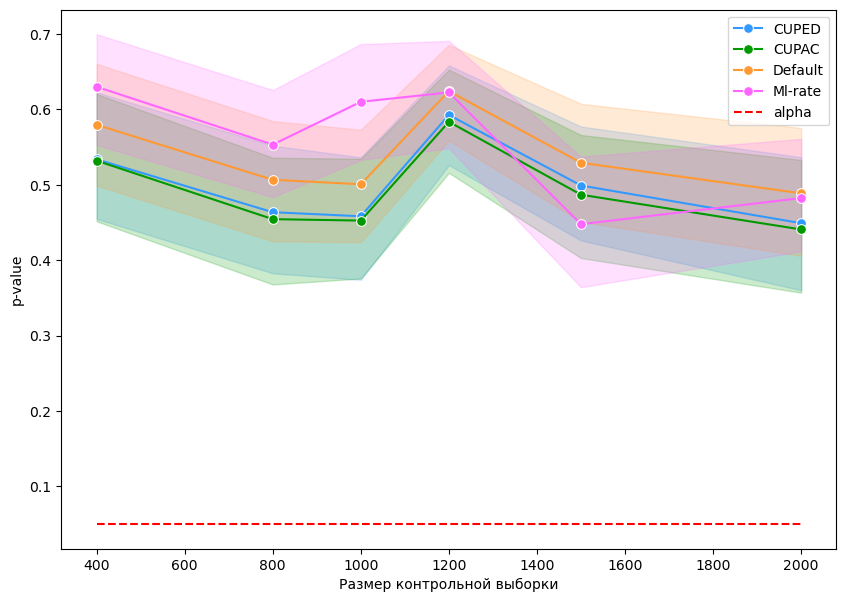

In [58]:
f = plt.subplots(1, figsize=(10, 7))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='CUPAC', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Default', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Ml-rate', marker="o", markersize=7, color='#ff66ff')

plt.plot(sizes, [0.05] * len(sizes), color="#ff0000", linestyle='dashed', label='alpha')
# plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')
plt.legend()
plt.show()